# Part 3 ‑ Predictive modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active
in their 6th month on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its longterm
rider retention (again, a few sentences will suffice).

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import json
from scipy import stats

from tqdm import tqdm_notebook as tqdm
tqdm().pandas()



import warnings 
warnings.simplefilter(action='ignore', category=FutureWarning)
import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

sns.set()

/Users/justin/anaconda3/lib/python3.7/site-packages/tqdm/std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
with open('ultimate_data_challenge.json') as json_file:
    data = json.load(json_file)

In [3]:
df1 = pd.DataFrame(data)

In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
city                      50000 non-null object
trips_in_first_30_days    50000 non-null int64
signup_date               50000 non-null object
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
last_trip_date            50000 non-null object
phone                     49604 non-null object
surge_pct                 50000 non-null float64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


From the info above we can see there exist 3 columns which include NaN value, for the phone columns, I am going to drop those rows which contains NaN, since we can not really filled in Android or iPhone by random guess. For the 2 rating columns, especially avg_rating_of_driver, it is pretty normal for customer not giving reviews for thier drivers, which results in the column having the largest portion of NaN values among all other columns. For the 2 rating columns, I am going to filled avg_rating_by_driver with their avg_rating_of_driver, vice versa, since the plot of the 2 rating columns seems to be  pretty symmetric (first plot in 1.2).

In [5]:
df2 = df1.dropna(subset=['phone']).reset_index(drop=True)

In [6]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49604 entries, 0 to 49603
Data columns (total 12 columns):
city                      49604 non-null object
trips_in_first_30_days    49604 non-null int64
signup_date               49604 non-null object
avg_rating_of_driver      41578 non-null float64
avg_surge                 49604 non-null float64
last_trip_date            49604 non-null object
phone                     49604 non-null object
surge_pct                 49604 non-null float64
ultimate_black_user       49604 non-null bool
weekday_pct               49604 non-null float64
avg_dist                  49604 non-null float64
avg_rating_by_driver      49406 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [7]:
# df2.avg_rating_by_driver.value_counts()
# df2.avg_rating_of_driver.value_counts()

For the rows with both ratings column = 0, going to first filled them  with the median of each column.

In [8]:
df2.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,49604.000000,41578.000000,49604.000000,49604.000000,49604.000000,49604.000000,49406.000000
mean,2.277256,4.601467,1.074991,8.875314,60.883832,5.785418,4.777861
std,3.793300,0.617377,0.222666,19.989018,37.086239,5.669709,0.447114
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.700000,100.000000,6.930000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


There are no 0 in both columns, going to turn nan into 0 and try to fill 0 in each column with the other column.

In [9]:
df = df2.fillna(0)

In [10]:
for i in tqdm(range(0, len(df))):
    if ((df.avg_rating_of_driver.iloc[i]==np.nan)\
       & (df.avg_rating_by_driver.iloc[i]==np.nan)):
        df.avg_rating_of_driver.iloc[i]=4.9
        df.avg_rating_by_driver.iloc[i]=5.0

In [11]:
for i in tqdm(range(0, len(df))):
    if ((df.avg_rating_of_driver.iloc[i] == 0)\
        & (df.avg_rating_by_driver.iloc[i] != 0)):
        df.avg_rating_of_driver.iloc[i] = df.avg_rating_by_driver.iloc[i]
   
    elif ((df.avg_rating_of_driver.iloc[i] != 0)\
          & (df.avg_rating_by_driver.iloc[i] == 0)):
          df.avg_rating_by_driver.iloc[i] = df.avg_rating_of_driver.iloc[i]
            

/Users/justin/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [12]:
# df.info()

Data description
* city: city this user signed up in
* phone: primary device for this user
* signup_date: date of account registration; in the form ‘YYYY MM DD’
* last_trip_date: the last time this user completed a trip; in the form ‘YYYY MM DD’
* avg_dist: the average distance in miles per trip taken in the first 30 days after signup
* avg_rating_by_driver: the rider’s average rating over all of their trips
* avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
* surge_pct: the percent of trips taken with surge multiplier > 1
* avg_surge: The average surge multiplier over all of this user’s trips
* trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up
* ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days;FALSE otherwise
* weekday_pct: the percent of the user’s trips occurring during a weekday

In [80]:
def normality_test(x):
    if stats.normaltest(x)[1] < 0.05:
        print("P_value: ", stats.normaltest(x)[1], "< 0.05, reject null hypothese, this distribution is not normal")
    else:
        print("P_value: ", stats.normaltest(x)[1], ">= 0.05, this distribution is normal")
            

In [81]:
def mann_whitney_u(x, y):
    if stats.mannwhitneyu(x, y, alternative='less')[1] < 0.05:
        print("P_value: ", stats.mannwhitneyu(x, y)[1], "< 0.05, x is less than y")
    elif stats.mannwhitneyu(x, y, alternative='greater')[1] < 0.05:
        print("P_value: ", stats.mannwhitneyu(x, y)[1], "< 0.05, x is greater than y")
    else:
        print('Cannot say x>y and x<y')
        

In [82]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [83]:
df.last_trip_date.sort_values(ascending=False).value_counts()

2014-06-29    2019
2014-06-28    1670
2014-06-30    1401
2014-06-27    1109
2014-06-22    1020
              ... 
2014-03-11      79
2014-02-19      78
2014-02-20      73
2014-03-04      68
2014-03-10      66
Name: last_trip_date, Length: 182, dtype: int64

In [84]:
df.trips_in_first_30_days.describe()

count    49604.000000
mean         2.277256
std          3.793300
min          0.000000
25%          0.000000
50%          1.000000
75%          3.000000
max        125.000000
Name: trips_in_first_30_days, dtype: float64

P_value:  0.0 < 0.05, reject null hypothese, this distribution is not normal


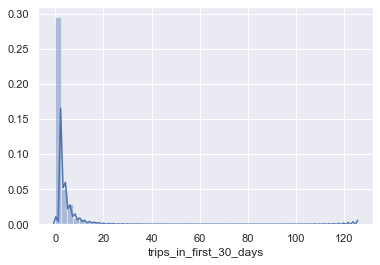

In [18]:
sns.distplot(df.trips_in_first_30_days);
normality_test(df.trips_in_first_30_days)

In [19]:
df.avg_dist.describe()

count    49604.000000
mean         5.785418
std          5.669709
min          0.000000
25%          2.420000
50%          3.880000
75%          6.930000
max        160.960000
Name: avg_dist, dtype: float64

P_value:  0.0 < 0.05, reject null hypothese, this distribution is not normal


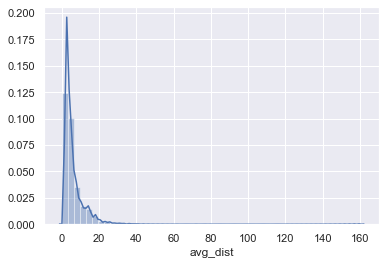

In [20]:
sns.distplot(df.avg_dist);
normality_test(df.avg_dist)

## 1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

Since the defintion of retained user is: The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days. Am going to first calculate the percentage of trips_in_first_30_days column, and then perform some analysis to see if I can find any interesing facts.

In [21]:
not_retain_user = df[df.trips_in_first_30_days==0]
retain_user = df[df.trips_in_first_30_days!=0]


The retaintion rate of Ultimate is 69.22%

In [22]:
retain_percentage = len(retain_user)/len(df)
retain_percentage


0.6913152165147972

### 1.1 Retain rate & trips_in_first_30_days VS phone

I am curious if the use of differnent types of phones will affect the amount of trips in first 30 days. From the boxplot and the rate, we cannot tell which phone user will take more trips in first 30 days. By plotting and performing the distribution test, both of the distribution are not normal, which Mann Whitney U test can be used here to determine which phone user will take more trip using Ultimate in first 30 days. From the result below, we can conclude that people using iPhone seems to take more trip in first 30 days compare to Android phone users. For people who use Ultimate, iPhone users doubled Android users.

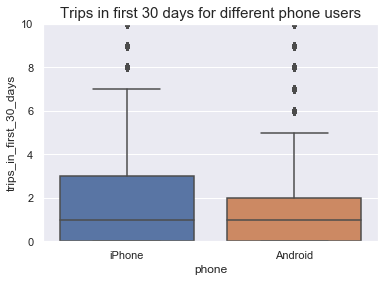

In [23]:
phone_retain_plot = sns.boxplot(df.phone, df.trips_in_first_30_days);
plt.title("Trips in first 30 days for different phone users", size=15);
phone_retain_plot.set_ylim(0, 10);


In [24]:
print('iPhone retain user rate:', len(retain_user[retain_user.phone=='iPhone'])/len(df[df.phone=='iPhone']))

iPhone retain user rate: 0.6907350644844139


In [25]:
print('Android retain user rate:', len(retain_user[retain_user.phone=='Android'])/len(df[df.phone=='Android']))

Android retain user rate: 0.6926507788576755


In [26]:
len(df[df.phone=='iPhone'])/len(df)

0.69716151923232

In [27]:
len(df[df.phone=='Android'])/len(df)

0.30283848076768005

P_value:  0.0 < 0.05, reject null hypothese, this distribution is not normal


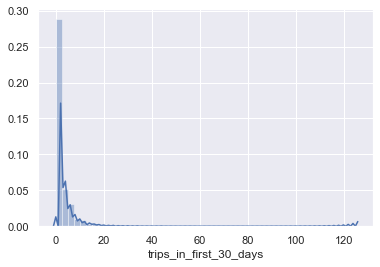

In [28]:
sns.distplot(df[df.phone=='iPhone'].trips_in_first_30_days);
normality_test(df[df.phone=='iPhone'].trips_in_first_30_days)

P_value:  0.0 < 0.05, reject null hypothese, this distribution is not normal


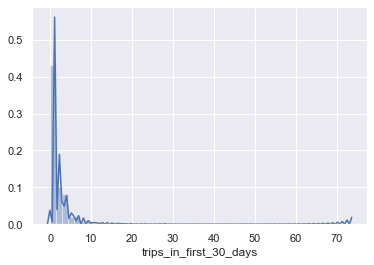

In [29]:
sns.distplot(df[df.phone=='Android'].trips_in_first_30_days);
normality_test(df[df.phone=='Android'].trips_in_first_30_days)

In [30]:
mann_whitney_u(df[df.phone=='iPhone'].trips_in_first_30_days, df[df.phone=='Android'].trips_in_first_30_days)

P_value:  2.9379558985036516e-23 < 0.05, x is greater than y


### 1.2 Retain rate VS ultimate black user
ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days;FALSE otherwise

People who took Ultimate black in their first 30 days also took more trips in first 30 days compare to those who did not take Ultimate black in their first 30 days after registeration.

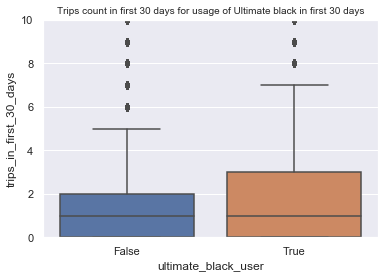

In [31]:
phone_retain_plot = sns.boxplot(df.ultimate_black_user, df.trips_in_first_30_days);
plt.title("Trips count in first 30 days for usage of Ultimate black in first 30 days", size=10);
phone_retain_plot.set_ylim(0, 10);

So the first thing I realized here is that taking the ultimate black in their first 30 days do not count as trip in first 30 days. 

In [32]:
df[(df.ultimate_black_user==True) & (df.trips_in_first_30_days==0)].head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
17,King's Landing,0,2014-01-12,3.9,1.0,2014-07-01,iPhone,0.0,True,95.2,2.38,4.8
23,King's Landing,0,2014-01-21,5.0,1.0,2014-06-13,Android,0.0,True,100.0,7.74,5.0
68,King's Landing,0,2014-01-01,5.0,1.0,2014-06-15,iPhone,0.0,True,0.0,4.44,5.0
79,Astapor,0,2014-01-23,5.0,1.0,2014-06-01,Android,0.0,True,66.7,10.49,5.0
84,Astapor,0,2014-01-09,4.0,1.0,2014-06-30,iPhone,0.0,True,100.0,5.01,5.0


In [33]:
len(df[df.ultimate_black_user==True])/len(df)

0.3752116764777034

In [34]:
len(df[df.ultimate_black_user==False])/len(df)

0.6247883235222966

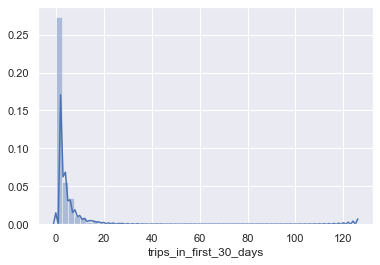

P_value:  0.0 < 0.05, reject null hypothese, this distribution is not normal


In [35]:
sns.distplot(df[df.ultimate_black_user==True].trips_in_first_30_days);
plt.show()
normality_test(df[df.ultimate_black_user==True].trips_in_first_30_days)

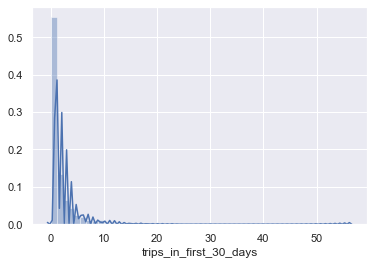

P_value:  0.0 < 0.05, reject null hypothese, this distribution is not normal


In [36]:
sns.distplot(df[df.ultimate_black_user==False].trips_in_first_30_days);
plt.show()
normality_test(df[df.ultimate_black_user==False].trips_in_first_30_days)

In [37]:
mann_whitney_u(df[df.ultimate_black_user==True].trips_in_first_30_days, df[df.ultimate_black_user==False].trips_in_first_30_days)

P_value:  6.042403717049951e-82 < 0.05, x is greater than y


### 1.3 avg_rating_of_driver VS avg_rating_by_driver VS trips in first 30 days

From the plot below, we can actually see that there are more points on the upper ende of the plot, which means driver gives higher score to customer compare to customer who rates their driver. 

From the Mann Whitney U test below, since trips in first 30 days for both higher avg rating group(by driver) and lower avg rating group(by driver) are not normally distributed, surprisingly, lower avg rating group(by driver) take more trip in first 30 days.

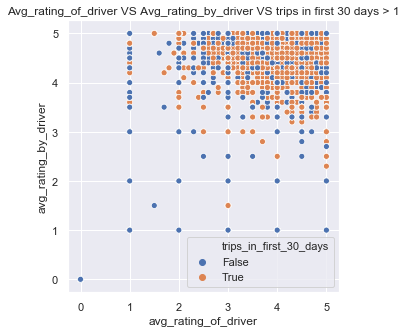

In [38]:
fig = plt.gcf()
fig.set_size_inches(5, 5)

sns.scatterplot(df.avg_rating_of_driver, df.avg_rating_by_driver, hue=df.trips_in_first_30_days > 1);
plt.title('Avg_rating_of_driver VS Avg_rating_by_driver VS trips in first 30 days > 1');

plt.gca().set_aspect('equal', adjustable='box')


In [39]:
higher_avg_rating_group = df[(df.avg_rating_by_driver >= 4.5) & (df.avg_rating_of_driver >= 4.5)]


In [40]:
list_high = list(higher_avg_rating_group.index)

In [41]:
lower_avg_rating_group = []

for i in range(0, len(df.index)):
    if i not in list_high:
        lower_avg_rating_group.append(i)

In [42]:
lower_avg_rating_group = df.iloc[lower_avg_rating_group]

P_value:  0.0 < 0.05, reject null hypothese, this distribution is not normal
percentage in high score group:  0.6916780904765745


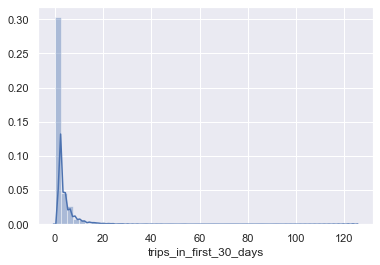

In [43]:
sns.distplot(higher_avg_rating_group.trips_in_first_30_days);
normality_test(higher_avg_rating_group.trips_in_first_30_days)
print('percentage in high score group: ',len(higher_avg_rating_group)/len(df))

P_value:  0.0 < 0.05, reject null hypothese, this distribution is not normal
percentage in lower score group:  0.30832190952342553


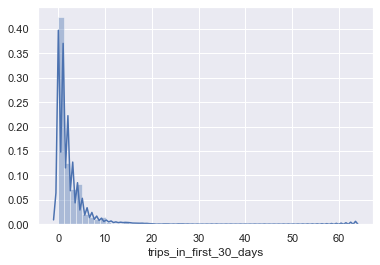

In [44]:
sns.distplot(lower_avg_rating_group.trips_in_first_30_days);
normality_test(lower_avg_rating_group.trips_in_first_30_days)
print('percentage in lower score group: ',len(lower_avg_rating_group)/len(df))


In [45]:
mann_whitney_u(higher_avg_rating_group.trips_in_first_30_days, lower_avg_rating_group.trips_in_first_30_days)


P_value:  2.47496297710178e-56 < 0.05, x is less than y


In [46]:
higher_avg_rating_group.trips_in_first_30_days.mean()

2.19594870300204

In [47]:
lower_avg_rating_group.trips_in_first_30_days.mean()

2.4596573819798615

### 1.4 Surge & trips in first 30 days

* surge_pct: the percent of trips taken with surge multiplier > 1
* avg_surge: The average surge multiplier over all of this user’s trips

From the two plots below, though it seems like that people with higher surge_pct/avg_surge seems to have lower trips in first 30 days, after statistics inference, the result shows that rider with higher surge_pct/avg_surge actually take more trip in first 30 days.

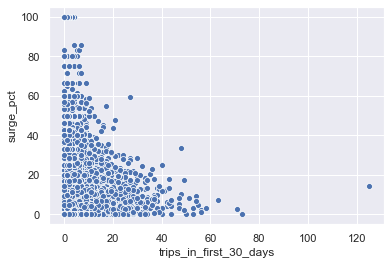

In [48]:
sns.scatterplot(df.trips_in_first_30_days, df.surge_pct);

In [49]:
normality_test(df[df.surge_pct>20].trips_in_first_30_days);

P_value:  0.0 < 0.05, reject null hypothese, this distribution is not normal


In [50]:
normality_test(df[df.surge_pct<=20].trips_in_first_30_days);

P_value:  0.0 < 0.05, reject null hypothese, this distribution is not normal


In [51]:
mann_whitney_u(df[df.surge_pct>20].trips_in_first_30_days, df[df.surge_pct<=20].trips_in_first_30_days)


P_value:  5.606414500474832e-07 < 0.05, x is greater than y


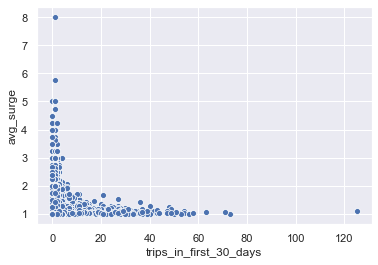

In [52]:
sns.scatterplot(df.trips_in_first_30_days, df.avg_surge);

In [53]:
normality_test(df[df.avg_surge>2].trips_in_first_30_days);

P_value:  1.9733321222175248e-38 < 0.05, reject null hypothese, this distribution is not normal


In [54]:
normality_test(df[df.avg_surge<=2].trips_in_first_30_days);

P_value:  0.0 < 0.05, reject null hypothese, this distribution is not normal


In [55]:
mann_whitney_u(df[df.surge_pct>2].trips_in_first_30_days, df[df.surge_pct<=2].trips_in_first_30_days)



P_value:  0.0 < 0.05, x is greater than y


### 1.5 Avg dist & trips in first 30 days

Interestingly, people who tend to take shorter trips, take more trips in first 30 days, vice versa

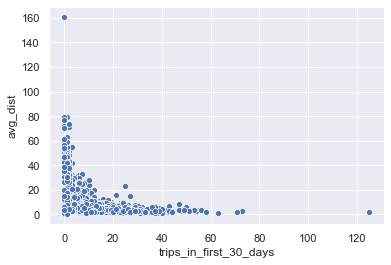

In [56]:
sns.scatterplot(df.trips_in_first_30_days, df.avg_dist);

In [57]:
normality_test(df[df.avg_dist>20].trips_in_first_30_days);

P_value:  0.0 < 0.05, reject null hypothese, this distribution is not normal


In [58]:
normality_test(df[df.avg_dist<=20].trips_in_first_30_days);

P_value:  0.0 < 0.05, reject null hypothese, this distribution is not normal


In [59]:
mann_whitney_u(df[df.avg_dist>20].trips_in_first_30_days, df[df.avg_dist<=20].trips_in_first_30_days)


P_value:  3.8359766256168526e-67 < 0.05, x is less than y


### 1.6 Weekday_pct & trips in first 30 days
From the plot and statistics inference below, results show that people who take more trip in weekdays tend to take more trips in first 30 days.

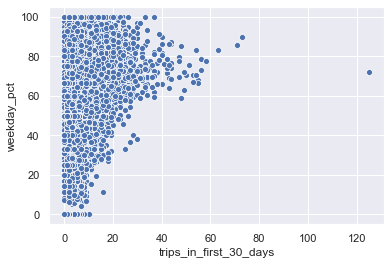

In [60]:
sns.scatterplot(df.trips_in_first_30_days, df.weekday_pct);

In [61]:
normality_test(df[df.weekday_pct>50].trips_in_first_30_days);

P_value:  0.0 < 0.05, reject null hypothese, this distribution is not normal


In [62]:
normality_test(df[df.weekday_pct<=50].trips_in_first_30_days);

P_value:  0.0 < 0.05, reject null hypothese, this distribution is not normal


In [63]:
mann_whitney_u(df[df.weekday_pct>50].trips_in_first_30_days, df[df.weekday_pct<=50].trips_in_first_30_days)


P_value:  6.806731897052534e-76 < 0.05, x is greater than y


## 2.Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.


### 2.1  Extract strategy I: Fail(Need to set thershold first)

To know what kind of riders retained 6 month after they signed up, I have to first extract riders in the dataframe who has signed up for more than 6 months. From the sorted values below, we can see that the data we are going to extract out for training will be those who signed up on 2014-01-01, since the latest last trip day is 2014-07-01, these people will be define as active user after 6 months, going to first extract those who signed up on 2014-01-01, and decide how to define if they are active users or not later.



In [13]:
df.last_trip_date.sort_values(ascending=False)

31351    2014-07-01
11999    2014-07-01
18667    2014-07-01
12053    2014-07-01
45166    2014-07-01
            ...    
3753     2014-01-01
31413    2014-01-01
32993    2014-01-01
25839    2014-01-01
38503    2014-01-01
Name: last_trip_date, Length: 49604, dtype: object

In [14]:
df_signup_date = pd.to_datetime(df.signup_date)

In [15]:
df_last_trip_date = pd.to_datetime(df.last_trip_date)

In [16]:
for_fitting = df[df.signup_date=='2014-01-01']

In [17]:
for_fitting.sort_values('last_trip_date', ascending=False).head(100)

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
18533,King's Landing,2,2014-01-01,4.6,1.03,2014-07-01,iPhone,7.7,False,69.2,3.94,4.8
23035,Winterfell,1,2014-01-01,4.7,1.00,2014-07-01,iPhone,0.0,False,50.0,4.05,4.7
34202,King's Landing,1,2014-01-01,4.7,1.13,2014-07-01,iPhone,33.3,False,38.1,3.00,4.7
17962,Astapor,2,2014-01-01,5.0,1.00,2014-07-01,iPhone,0.0,False,100.0,4.57,5.0
21777,Winterfell,0,2014-01-01,4.5,1.06,2014-07-01,Android,9.1,False,77.3,4.10,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...
40032,Winterfell,0,2014-01-01,4.0,2.25,2014-06-29,iPhone,100.0,True,0.0,11.94,5.0
29028,King's Landing,0,2014-01-01,4.5,1.00,2014-06-29,iPhone,0.0,False,83.3,10.33,4.9
7557,Astapor,0,2014-01-01,4.4,1.08,2014-06-29,iPhone,14.3,False,38.1,2.85,4.9
4971,Winterfell,0,2014-01-01,4.4,1.07,2014-06-29,iPhone,7.1,False,64.3,1.75,4.7


In [18]:
for_fitting['active_interval'] = pd.to_datetime(for_fitting['last_trip_date']) - pd.to_datetime(for_fitting['signup_date'])

/Users/justin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [19]:
for_fitting.sort_values('active_interval', ascending=False)

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active_interval
18533,King's Landing,2,2014-01-01,4.6,1.03,2014-07-01,iPhone,7.7,False,69.2,3.94,4.8,181 days
23035,Winterfell,1,2014-01-01,4.7,1.00,2014-07-01,iPhone,0.0,False,50.0,4.05,4.7,181 days
34202,King's Landing,1,2014-01-01,4.7,1.13,2014-07-01,iPhone,33.3,False,38.1,3.00,4.7,181 days
17962,Astapor,2,2014-01-01,5.0,1.00,2014-07-01,iPhone,0.0,False,100.0,4.57,5.0,181 days
21777,Winterfell,0,2014-01-01,4.5,1.06,2014-07-01,Android,9.1,False,77.3,4.10,4.9,181 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11496,Winterfell,1,2014-01-01,5.0,1.00,2014-01-01,Android,0.0,True,100.0,18.63,5.0,0 days
32926,Winterfell,1,2014-01-01,4.0,1.00,2014-01-01,Android,0.0,False,100.0,1.55,4.0,0 days
32993,Winterfell,1,2014-01-01,4.0,1.00,2014-01-01,iPhone,0.0,False,100.0,6.83,3.0,0 days
7608,Winterfell,1,2014-01-01,5.0,1.00,2014-01-01,iPhone,0.0,True,100.0,3.39,5.0,0 days


In [20]:
for_fitting['active_interval_1'] = for_fitting.active_interval.replace('days','')


/Users/justin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [21]:
for_fitting.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active_interval,active_interval_1
68,King's Landing,0,2014-01-01,5.0,1.0,2014-06-15,iPhone,0.0,True,0.0,4.44,5.0,165 days,165 days
71,Astapor,1,2014-01-01,5.0,1.0,2014-01-01,Android,0.0,False,100.0,1.02,5.0,0 days,0 days
77,Astapor,0,2014-01-01,5.0,1.0,2014-02-03,iPhone,0.0,False,100.0,19.80,5.0,33 days,33 days
104,Winterfell,3,2014-01-01,3.0,1.0,2014-06-28,iPhone,0.0,True,63.6,4.08,4.9,178 days,178 days
113,Winterfell,1,2014-01-01,5.0,1.0,2014-03-29,Android,0.0,False,33.3,10.29,3.7,87 days,87 days


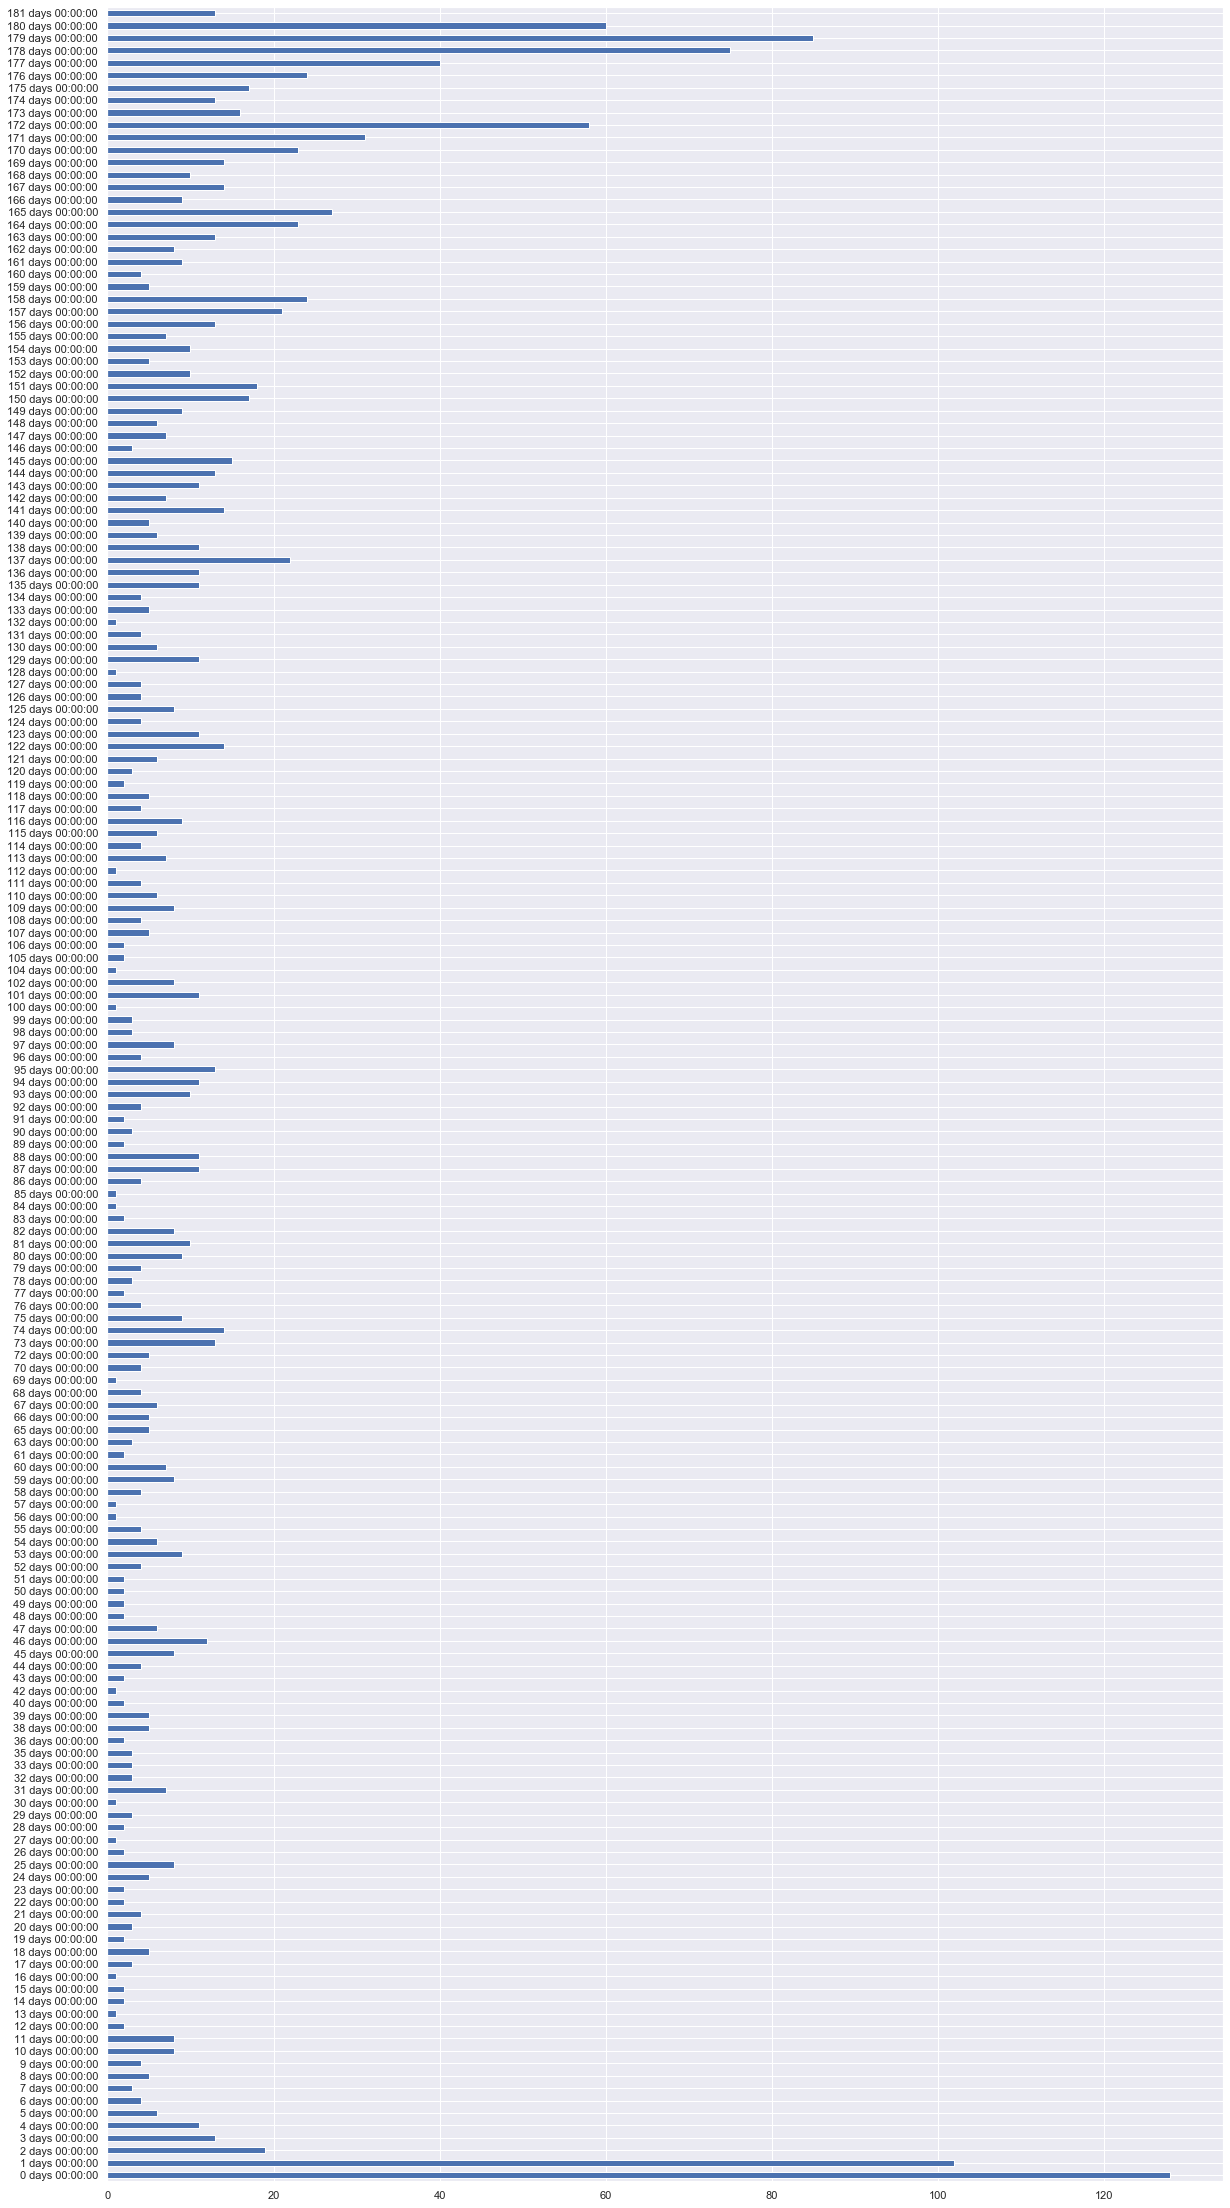

In [22]:
fig = plt.gcf();
fig.set_size_inches(20, 40);

for_fitting.active_interval.value_counts().sort_index(ascending=True).plot(kind='barh');


### 2.2 Set a thershold

In [13]:
df['active_interval'] = pd.to_datetime(df['last_trip_date']) - pd.to_datetime(df['signup_date'])

In [14]:
df.sort_values(['active_interval'], ascending=False)
df.reset_index(drop=True)

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active_interval
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,143 days
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,96 days
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,1 days
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,170 days
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,47 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49599,King's Landing,0,2014-01-25,5.0,1.00,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2,131 days
49600,Astapor,1,2014-01-24,4.0,1.00,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0,1 days
49601,Winterfell,0,2014-01-31,5.0,1.00,2014-05-22,Android,0.0,True,100.0,3.86,5.0,111 days
49602,Astapor,2,2014-01-14,3.0,1.00,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5,1 days


To predict if those who register are still active after six month I decide to take those who register on Jan-01 and Jan-02 as training set, and if they are still active on last week of this data set, I am going to count them as active. 

In [15]:
train1 = df[(df.signup_date=='2014-01-01') |\
            (df.signup_date=='2014-01-02')]

In [16]:
train1['active_user']=0
pd.set_option('display.max_rows', 10)
train = train1.sort_values('active_interval', ascending=False)


/Users/justin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [17]:
train.reset_index(drop=True)
train.active_user.iloc[:486]=1

In [18]:
test_index = []

for i in tqdm(range(0, len(df))):
    if i not in train1.index:
        test_index.append(i)

In [19]:
test = df.iloc[test_index]

### 2.3 Machine Learning:

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
from sklearn import preprocessing
plt.rc("font", size=14)
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score



sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



pd.set_option('display.max_columns', None)

from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

### 2.3.1 Logistic Regression

In [21]:
from sklearn.linear_model import LogisticRegression

In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2724 entries, 25247 to 31357
Data columns (total 14 columns):
city                      2724 non-null object
trips_in_first_30_days    2724 non-null int64
signup_date               2724 non-null object
avg_rating_of_driver      2724 non-null float64
avg_surge                 2724 non-null float64
last_trip_date            2724 non-null object
phone                     2724 non-null object
surge_pct                 2724 non-null float64
ultimate_black_user       2724 non-null bool
weekday_pct               2724 non-null float64
avg_dist                  2724 non-null float64
avg_rating_by_driver      2724 non-null float64
active_interval           2724 non-null timedelta64[ns]
active_user               2724 non-null int64
dtypes: bool(1), float64(6), int64(2), object(4), timedelta64[ns](1)
memory usage: 300.6+ KB


In [23]:
train.active_interval.astype(str)

25247    181 days 00:00:00.000000000
34694    181 days 00:00:00.000000000
21777    181 days 00:00:00.000000000
38911    181 days 00:00:00.000000000
23035    181 days 00:00:00.000000000
                    ...             
16740      0 days 00:00:00.000000000
3334       0 days 00:00:00.000000000
3369       0 days 00:00:00.000000000
22572      0 days 00:00:00.000000000
31357      0 days 00:00:00.000000000
Name: active_interval, Length: 2724, dtype: object

training_set put in date will not work for test set, since if test set have 2019 it will not fit. 

Cannot put the interval into for training, since if interval > 173, it will be true, if not it will be false, thats why I obtained 100% F1 score, since I put in the active interval, and this will not be useful since the testing date set will not have any days > 173, so will have a serious overfitting problem.

In [24]:
ohe_city = pd.get_dummies(train.city)
ohe_ultimate_black_user = pd.get_dummies(train.ultimate_black_user)
ohe_phone = pd.get_dummies(train.phone)

train_drop = train.drop(['city', 'signup_date', 'last_trip_date', 'ultimate_black_user', 'active_interval', 'phone'], axis=1)

train_ohe = pd.concat([train_drop, ohe_city, ohe_ultimate_black_user, ohe_phone], axis=1)


In [25]:
test = train_ohe.active_user
train = train_ohe.drop('active_user', axis=1)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(train, test, random_state=0, test_size=0.2)

In [35]:
lr = LogisticRegression(random_state=0)
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [28]:
y_pred = lr.predict(X_test)

In [46]:
lr_cv_score = cross_val_score(lr, X_train, y_train, cv=5, scoring='roc_auc')
lr_cv_score1 = cross_val_score(lr, X_train, y_train, cv=5, scoring='f1')


In [47]:
print("=== f1 score on test===")
print(f1_score(y_test, y_pred))
print('\n')
print("=== Confusion Matrix on test===")
print(confusion_matrix(y_test, y_pred))
print('\n')
print("=== Classification Report on test===")
print(classification_report(y_test, y_pred))
print('\n')
print("=== All AUC Scores on CV===")
print(lr_cv_score)
print('\n')
print("=== Mean AUC Score on CV===")
print("Mean AUC Score: ", lr_cv_score.mean())
print('\n')
print("=== All f1 Scores on CV===")
print(lr_cv_score1)
print('\n')
print("=== Mean f1 Score on CV===")
print("Mean f1 Score: ", lr_cv_score1.mean())

=== f1 score on test===
0.0606060606060606


=== Confusion Matrix on test===
[[449   2]
 [ 91   3]]


=== Classification Report on test===
              precision    recall  f1-score   support

           0       0.83      1.00      0.91       451
           1       0.60      0.03      0.06        94

    accuracy                           0.83       545
   macro avg       0.72      0.51      0.48       545
weighted avg       0.79      0.83      0.76       545



=== All AUC Scores on CV===
[0.70270844 0.75967046 0.70882712 0.6944624  0.6841198 ]


=== Mean AUC Score on CV===
Mean AUC Score:  0.7099576441885207


=== All f1 Scores on CV===
[0.06818182 0.13793103 0.24175824 0.06976744 0.17021277]


=== Mean f1 Score on CV===
Mean f1 Score:  0.13757026044814608


In [76]:
coef = pd.DataFrame(lr.coef_).T

In [81]:
coef.set_index(X_train.columns).sort_values(0, ascending=False)

,0
King's Landing,0.587670
iPhone,0.359624
trips_in_first_30_days,0.103870
True,0.060021
surge_pct,0.006875
...,...
avg_rating_by_driver,-0.159797
Winterfell,-0.201177
False,-0.374946
Android,-0.674548


In [ ]:
stats model/ feature importance/ shap lime-- feature importnace

### 2.3.2 Random Forest Regressor

In [31]:
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier



In [32]:
rfc = RandomForestClassifier(bootstrap=True, criterion='gini', max_depth=4, max_features='auto', min_samples_leaf=1, min_samples_split=5, n_estimators=100, random_state=0)

rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=4, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [33]:
rfc_predict = rfc.predict(X_test)


In [39]:
rfc_cv_score = cross_val_score(rfc, X_train, y_train, cv=10, scoring='roc_auc')
rfc_cv_score1 = cross_val_score(rfc, X_train, y_train, cv=10, scoring='f1')



In [40]:
print("=== f1 score on test===")
print(f1_score(y_test, rfc_predict))
print('\n')
print("=== Confusion Matrix on test===")
print(confusion_matrix(y_test, rfc_predict))
print('\n')
print("=== Classification Report on test===")
print(classification_report(y_test, rfc_predict))
print('\n')
print("=== All AUC Scores on CV===")
print(rfc_cv_score)
print('\n')
print("=== Mean AUC Score on CV===")
print("Mean AUC Score: ", rfc_cv_score.mean())
print('\n')
print("=== All f1 Scores on CV===")
print(rfc_cv_score1)
print('\n')
print("=== Mean f1 Score on CV===")
print("Mean f1 Score: ", rfc_cv_score1.mean())

=== f1 score on test===
0.19999999999999998


=== Confusion Matrix on test===
[[446   5]
 [ 83  11]]


=== Classification Report on test===
              precision    recall  f1-score   support

           0       0.84      0.99      0.91       451
           1       0.69      0.12      0.20        94

    accuracy                           0.84       545
   macro avg       0.77      0.55      0.56       545
weighted avg       0.82      0.84      0.79       545



=== All AUC Scores on CV===
[0.87234637 0.83833799 0.87981665 0.83705773 0.76192523 0.84156998
 0.79680562 0.73098531 0.70779314 0.78190723]


=== Mean AUC Score on CV===
Mean AUC Score:  0.8048545228702627


=== All f1 Scores on CV===
[0.17391304 0.20408163 0.29787234 0.21276596 0.32       0.38461538
 0.22222222 0.04255319 0.15384615 0.12244898]


=== Mean f1 Score on CV===
Mean f1 Score:  0.21343189057686218


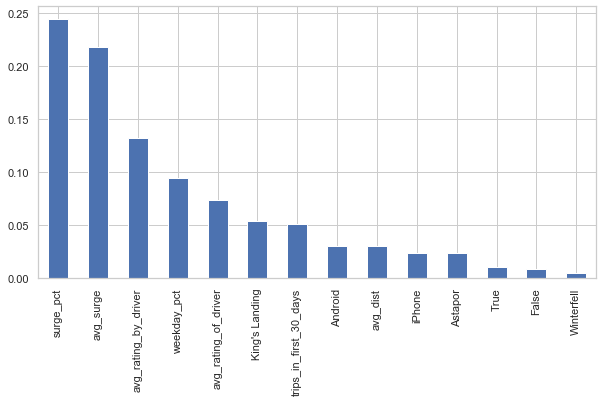

In [41]:
fig = plt.gcf();
fig.set_size_inches(10, 5);

feat_importances = pd.Series(rfc.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='bar');

### 2.3.3 PCA

In [89]:
from sklearn.decomposition import PCA
pca = PCA(random_state=0, n_components=2)


In [90]:
principalComponents = pca.fit_transform(train)



In [91]:
pca.explained_variance_ratio_



array([0.74112765, 0.23318074])

In [92]:
X_train, X_test, y_train, y_test = train_test_split(train, test, test_size=0.2, random_state=0)



In [98]:
pca = PCA(random_state=0)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [94]:
# solver = 'lbfgs' -- will make it run faster

lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [95]:
y_pred = lr.predict(X_test)

In [96]:
lr_cv_score = cross_val_score(lr, X_train, y_train, cv=10, scoring='roc_auc')
lr_cv_score1 = cross_val_score(lr, X_train, y_train, cv=10, scoring='f1')

In [97]:
print("=== f1 score on test===")
print(f1_score(y_test, y_pred))
print('\n')
print("=== Confusion Matrix on test===")
print(confusion_matrix(y_test, y_pred))
print('\n')
print("=== Classification Report on test===")
print(classification_report(y_test, y_pred))
print('\n')
print("=== All AUC Scores on CV===")
print(lr_cv_score)
print('\n')
print("=== Mean AUC Score on CV===")
print("Mean AUC Score: ", lr_cv_score.mean())
print('\n')
print("=== All f1 Scores on CV===")
print(lr_cv_score1)
print('\n')
print("=== Mean f1 Score on CV===")
print("Mean f1 Score: ", lr_cv_score1.mean())

=== f1 score on test===
0.0606060606060606


=== Confusion Matrix on test===
[[449   2]
 [ 91   3]]


=== Classification Report on test===
              precision    recall  f1-score   support

           0       0.83      1.00      0.91       451
           1       0.60      0.03      0.06        94

    accuracy                           0.83       545
   macro avg       0.72      0.51      0.48       545
weighted avg       0.79      0.83      0.76       545



=== All AUC Scores on CV===
[0.66187151 0.73212291 0.79172038 0.71923793 0.66108007 0.75476293
 0.70878098 0.67747047 0.65687122 0.73177759]


=== Mean AUC Score on CV===
Mean AUC Score:  0.7095695982192436


=== All f1 Scores on CV===
[0.09090909 0.04444444 0.29787234 0.09302326 0.17391304 0.22727273
 0.04761905 0.04651163 0.17021277 0.13636364]


=== Mean f1 Score on CV===
Mean f1 Score:  0.13281419801911168


### 2.3.4 KNN

In [50]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)



KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [51]:
y_pred = knn.predict(X_test)



In [56]:
cv_score = cross_val_score(knn, X_train, y_train, cv=5, scoring='roc_auc')
cv_score1 = cross_val_score(knn, X_train, y_train, cv=5, scoring='f1')

In [57]:
print("=== f1 score on test===")
print(f1_score(y_test, y_pred))
print('\n')
print("=== Confusion Matrix on test===")
print(confusion_matrix(y_test, y_pred))
print('\n')
print("=== Classification Report on test===")
print(classification_report(y_test, y_pred))
print('\n')
print("=== All AUC Scores on CV===")
print(cv_score)
print('\n')
print("=== Mean AUC Score on CV===")
print("Mean AUC Score: ", cv_score.mean())
print('\n')
print("=== All f1 Scores on CV===")
print(cv_score1)
print('\n')
print("=== Mean f1 Score on CV===")
print("Mean f1 Score: ", cv_score1.mean())

=== f1 score on test===
0.3380281690140845


=== Confusion Matrix on test===
[[427  24]
 [ 70  24]]


=== Classification Report on test===
              precision    recall  f1-score   support

           0       0.86      0.95      0.90       451
           1       0.50      0.26      0.34        94

    accuracy                           0.83       545
   macro avg       0.68      0.60      0.62       545
weighted avg       0.80      0.83      0.80       545



=== All AUC Scores on CV===
[0.79257125 0.80328477 0.7597321  0.71512964 0.67507003]


=== Mean AUC Score on CV===
Mean AUC Score:  0.7491575578153198


=== All f1 Scores on CV===
[0.13636364 0.11494253 0.2020202  0.16842105 0.10869565]


=== Mean f1 Score on CV===
Mean f1 Score:  0.14608861438499252


In [53]:
error = []

# Calculating error for K values between 1 and 40
for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Mean Error')

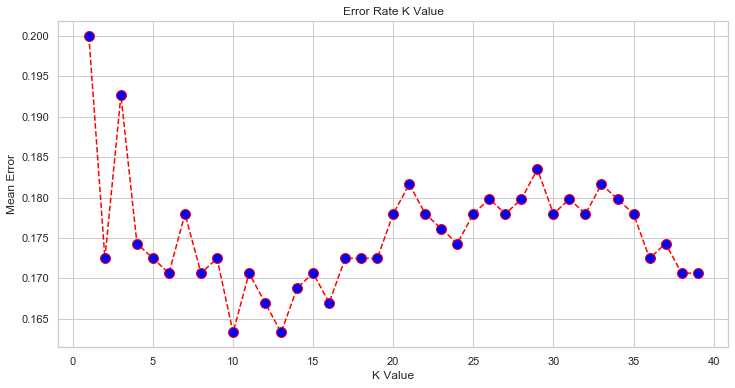

In [54]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

### 2.3.5 SVC

In [108]:
from sklearn.svm import SVC


In [110]:
svm = SVC(random_state=0)
svm.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=0,
    shrinking=True, tol=0.001, verbose=False)

In [111]:
y_pred = svm.predict(X_test)

In [113]:
svm_cv_score = cross_val_score(svm, X_train, y_train, cv=10, scoring='roc_auc')
svm_cv_score1 = cross_val_score(svm, X_train, y_train, cv=10, scoring='f1')



In [114]:
print("=== f1 score on test===")
print(f1_score(y_test, y_pred))
print('\n')
print("=== Confusion Matrix on test===")
print(confusion_matrix(y_test, y_pred))
print('\n')
print("=== Classification Report on test===")
print(classification_report(y_test, y_pred))
print('\n')
print("=== All AUC Scores on CV===")
print(svm_cv_score)
print('\n')
print("=== Mean AUC Score on CV===")
print("Mean AUC Score: ", svm_cv_score.mean())
print('\n')
print("=== All f1 Scores on CV===")
print(svm_cv_score1)
print('\n')
print("=== Mean f1 Score on CV===")
print("Mean f1 Score: ", svm_cv_score1.mean())

=== f1 score on test===
0.16071428571428573


=== Confusion Matrix on test===
[[442   9]
 [ 85   9]]


=== Classification Report on test===
              precision    recall  f1-score   support

           0       0.84      0.98      0.90       451
           1       0.50      0.10      0.16        94

    accuracy                           0.83       545
   macro avg       0.67      0.54      0.53       545
weighted avg       0.78      0.83      0.78       545



=== All AUC Scores on CV===
[0.71005587 0.79231844 0.71064317 0.74072482 0.7150838  0.75333047
 0.74287351 0.62618842 0.65845578 0.73624316]


=== Mean AUC Score on CV===
Mean AUC Score:  0.7185917433998219


=== All f1 Scores on CV===
[0.20408163 0.25       0.13333333 0.24       0.22222222 0.13333333
 0.23076923 0.03921569 0.09302326 0.22222222]


=== Mean f1 Score on CV===
Mean f1 Score:  0.17682009166218662


### 2.3.6 Catboosting

In [29]:
from catboost import Pool, CatBoostClassifier



In [37]:
cat = CatBoostClassifier(random_state=0)

parameters = {'max_depth': [5, 6, 7], 'n_estimators': [70, 80 ,90], 'learning_rate':[0.05, 0.08, 0.1], 'random_state':[0], 'silent':[True]}
cat_cv = GridSearchCV(cat, param_grid=parameters, cv=5)

cat_cv.fit(X_train, y_train)
cat_cv.best_params_


{'learning_rate': 0.1,
 'max_depth': 6,
 'n_estimators': 90,
 'random_state': 0,
 'silent': True}

In [39]:
best_cat = CatBoostClassifier(max_depth=6, learning_rate=0.1, n_estimators=90, random_state=0, silent=True)

In [41]:
best_cat.fit(X_train, y_train);

In [42]:
y_pred = best_cat.predict(X_test)

In [47]:
cv_score = cross_val_score(best_cat, X_train, y_train, cv=5, scoring='roc_auc')
cv_score1 = cross_val_score(best_cat, X_train, y_train, cv=5, scoring='f1')

In [48]:
print("=== f1 score on test===")
print(f1_score(y_test, y_pred))
print('\n')
print("=== Confusion Matrix on test===")
print(confusion_matrix(y_test, y_pred))
print('\n')
print("=== Classification Report on test===")
print(classification_report(y_test, y_pred))
print('\n')
print("=== All AUC Scores on CV===")
print(cv_score)
print('\n')
print("=== Mean AUC Score on CV===")
print("Mean AUC Score: ", cv_score.mean())
print('\n')
print("=== All f1 Scores on CV===")
print(cv_score1)
print('\n')
print("=== Mean f1 Score on CV===")
print("Mean f1 Score: ", cv_score1.mean())

=== f1 score on test===
0.3795620437956204


=== Confusion Matrix on test===
[[434  17]
 [ 68  26]]


=== Classification Report on test===
              precision    recall  f1-score   support

           0       0.86      0.96      0.91       451
           1       0.60      0.28      0.38        94

    accuracy                           0.84       545
   macro avg       0.73      0.62      0.65       545
weighted avg       0.82      0.84      0.82       545



=== All AUC Scores on CV===
[0.86107772 0.87020013 0.81598793 0.79178338 0.75693098]


=== Mean AUC Score on CV===
Mean AUC Score:  0.8191960271476655


=== All f1 Scores on CV===
[0.3853211  0.4        0.41071429 0.31775701 0.2300885 ]


=== Mean f1 Score on CV===
Mean f1 Score:  0.3487761783105466


### 2.3.7 Gradient Boosting 

In [61]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

gbr = GradientBoostingClassifier(random_state=0)

parameters = {'max_depth': [10 ,11, 12], 'n_estimators': [90, 100, 110], 'max_features':['auto'], 'learning_rate':[0.1, 0.2, 0.3]}
gbr_cv = GridSearchCV(gbr, param_grid=parameters, cv=5)
gbr_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
                                                  presort=

In [62]:
gbr_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 10,
 'max_features': 'auto',
 'n_estimators': 100}

In [63]:
gbr_best = GradientBoostingClassifier(random_state=0, learning_rate=0.1, max_depth=10, max_features='auto', n_estimators=100)

In [64]:
gbr_best.fit(X_train, y_train)
y_pred = gbr_best.predict(X_test)

In [65]:
cv_score = cross_val_score(gbr_best, X_train, y_train, cv=5, scoring='roc_auc')
cv_score1 = cross_val_score(gbr_best, X_train, y_train, cv=5, scoring='f1')

In [66]:
print("=== f1 score on test===")
print(f1_score(y_test, y_pred))
print('\n')
print("=== Confusion Matrix on test===")
print(confusion_matrix(y_test, y_pred))
print('\n')
print("=== Classification Report on test===")
print(classification_report(y_test, y_pred))
print('\n')
print("=== All AUC Scores on CV===")
print(cv_score)
print('\n')
print("=== Mean AUC Score on CV===")
print("Mean AUC Score: ", cv_score.mean())
print('\n')
print("=== All f1 Scores on CV===")
print(cv_score1)
print('\n')
print("=== Mean f1 Score on CV===")
print("Mean f1 Score: ", cv_score1.mean())

=== f1 score on test===
0.41509433962264153


=== Confusion Matrix on test===
[[419  32]
 [ 61  33]]


=== Classification Report on test===
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       451
           1       0.51      0.35      0.42        94

    accuracy                           0.83       545
   macro avg       0.69      0.64      0.66       545
weighted avg       0.81      0.83      0.82       545



=== All AUC Scores on CV===
[0.79517007 0.81585461 0.79404582 0.76416721 0.74581628]


=== Mean AUC Score on CV===
Mean AUC Score:  0.7830107968075579


=== All f1 Scores on CV===
[0.47328244 0.39344262 0.45588235 0.3968254  0.31496063]


=== Mean f1 Score on CV===
Mean f1 Score:  0.4068786890773488


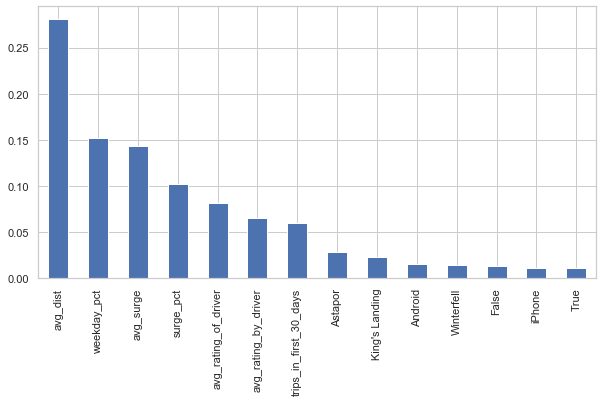

In [67]:
fig = plt.gcf();
fig.set_size_inches(10, 5);

feat_importances = pd.Series(gbr_best.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='bar');

## 3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its longtermrider retention (again, a few sentences will suffice).

So far, Gardient Boosting generate the best result, from the plot above we can see that average distance, weekday percentage, avergae surge, surge percentage, average rating of driver, average rating by driver, trips in first 30 days are all important feature for the model to make predict if a rider is going to retain in the app for the long term.